# Sistema de Recomendação

Este notebook apresenta algumas implementações de sistema de recomendação utilizando
o dataset Movielens.
Este notebook contém:
- Modelo de Sistema de Recomendação utilizando atributos latentes e produto interno
- Modelo utilizando atributos latentes concatenados e uma rede neural
- Calcula a predição para todos os filmes e usuários que não fizeram suas avaliações
- Visualiza a matriz de avaliações por usuários x filmes com todas as predições
- Análise do significado dos embeddings

Obs: Este notebook foi inspirado em exemplo divulgado pelo curso online disponível em [fast.ai](http://fast.ai)

## Importação da bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd

import keras
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers import Input, Embedding
from keras.models import Model
from keras.regularizers import l2
from keras.layers.core import Flatten, Dense, Dropout
from keras.optimizers import SGD, RMSprop, Adam, Adadelta

np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

Using TensorFlow backend.


## Funções de apoio ao treinamento

In [25]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["mse"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, metric_v = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] {:s} on the test data set: {:1.2f} [{:1.5f}]".format(model.metrics_names[1],metric_v, loss))
    return model


## Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


### Leitura dos Dados - Movielens dataset

Caso a célula a seguir falhar, é necessário executar o notebook:
- [Movielens Dataset](MovieLens_dataset.ipynb) que é responsável por ler o dataset original e
prepará-lo para este notebook

Este dataset consiste de:
- 100.004 avaliações de filmes (amostras), feitas por
- 671 usuários, sobre
- 9066 filmes

As amostras estão no array `ratings` organizados da seguinte forma:
- cada linha é uma amostra
- coluna 0 é o iD do usuário
- coluna 1 é o iD do filme
- coluna 2 é a avaliação do usuários entre 0.0 e 5.0

In [3]:
data = np.load('../data/movielens_norm.npz')
ratings = data['ratings']
movie_names = data['movie_names']
n_samples = ratings.shape[0]
print('n_samples:',n_samples)
print('ratings:\n', ratings[:5])

n_samples: 100004
ratings:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]


In [4]:
for i in (ratings[:5,1]).astype(np.int):
    print(movie_names[i])

Dangerous Minds (1995)
Dumbo (1941)
Sleepers (1996)
Escape from New York (1981)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [5]:
h_userId = np.bincount(ratings[:,0].astype(np.int))
n_users = h_userId.size
h_movieId = np.bincount(ratings[:,1].astype(np.int))
n_movies = h_movieId.size
print('n_users:',n_users)
print('n_movies:',n_movies)

n_users: 671
n_movies: 9066


## Divisão dos dados em treinamento e validação

In [6]:
np.random.seed = 42

Faz a divisão com 80% das amostras para treinamento e 20% para validação:

In [7]:
msk = np.random.rand(n_samples) < 0.8
train = ratings[msk]
valid = ratings[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 80154  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  1017.0  2.0]
 [ 0.0  1047.0  2.0]]
valid: 19850  amostras:
 [[ 0.0  833.0  3.0]
 [ 0.0  931.0  4.0]
 [ 0.0  1041.0  2.0]
 [ 1.0  58.0  3.0]
 [ 1.0  100.0  4.0]]


In [8]:
train_userId =  train[:,0]
train_movieId = train[:,1]
train_ratings = train[:,2]
valid_userId =  valid[:,0]
valid_movieId = valid[:,1]
valid_ratings = valid[:,2]

n_factors = 50

## Primeira solução - usando produto interno: Dot

<img src='../figures/Recomendacao_dot.png', width=600ptx></img>

O primeiro modelo é o produto interno entre os atributos latentes dos usuários e dos filmes.
Este produto interno é implementado pela operação `dot` do Keras. Como o modelo agora não é
sequencial, há necessidade de utilizarmos o modelo API:

In [9]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, 
              input_length=1, 
              embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, 
              input_length=1, 
              embeddings_regularizer=l2(1e-4))(movie_in)
x = keras.layers.dot([u, m],axes=-1)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

### Treinando a rede

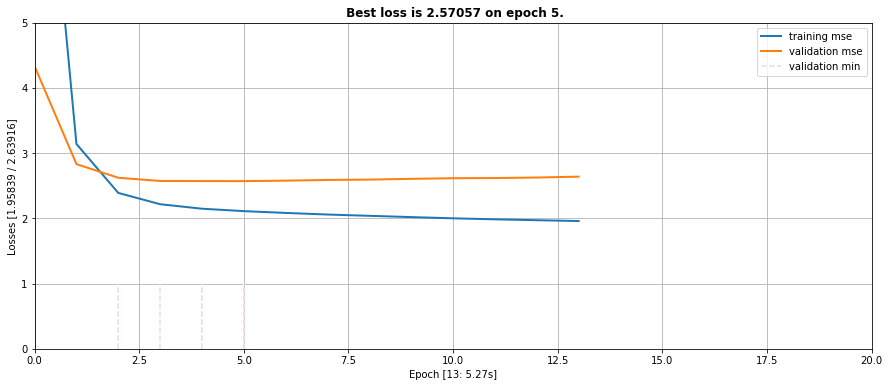

In [11]:
model_name = '../../models/Recomendacao_dot'
fit_params = {
    'model_name': model_name,
    'loss':       'mse',
    'opt':        Adam(), 
    'batch_size': 64, 
    'nepochs':    20,
    'patience':   5,
    'ploss':      5.,
    'reset':      False,
}

train_network(model, 
              [train_userId, train_movieId], train_ratings, 
              [valid_userId, valid_movieId], valid_ratings, **fit_params);

### Avaliando a rede

In [26]:
model = test_network(model_name, [valid_userId, valid_movieId], valid_ratings)

Model from epoch 3
[INFO] evaluating in the test data set ...
18816/19850 [===========================>..] - ETA: 0s
[INFO] mean_squared_error on the test data set: 1.50 [2.56831]


Os bons modelos [best benchmarks](http://www.librec.net/example.html) são próximos de 0.9, há necessidade de melhorias.

### Predição de usuário e filme

Para calcular qualquer predição de qualquer usuário e qualquer filme, usa-se o `predict` do modelo treinado:

In [27]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.1]], dtype=float32)

##  Usado Rede Neural

<img src='../figures/Recomendacao_NN.png', width=600ptx></img>

Uma solução usando rede neural é concatenar a saída dos embeddings e em seguida colocar uma camada densa
antes da última camada de um neurônio. No exemplo a seguir foi utilizado uma camada de 70 neurônios.

In [14]:
user_in = Input(shape=(1,),dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, 
              embeddings_regularizer=l2(1e-4))(user_in)

movie_in = Input(shape=(1,),dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, 
              embeddings_regularizer=l2(1e-4))(movie_in)

In [15]:
x = keras.layers.concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
model_nn = Model([user_in, movie_in], x)
print(model_nn.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

### Treinando a rede

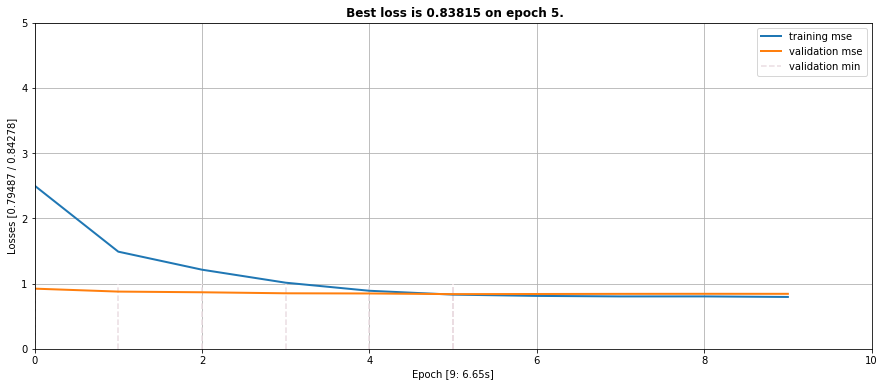

In [29]:
model_name = '../../models/Recomendacao_nn'
fit_params = {
    'model_name': model_name,
    'loss':       'mse',
    'opt':        Adam(), 
    'batch_size': 64, 
    'nepochs':    10,
    'patience':   5,
    'ploss':      3.,
    'reset':      False,
}

train_network(model_nn, 
              [train_userId, train_movieId], train_ratings, 
              [valid_userId, valid_movieId], valid_ratings, **fit_params);

### Avaliando a rede

In [30]:
model_nn = test_network(model_name, [valid_userId, valid_movieId], valid_ratings)

Model from epoch 5
[INFO] evaluating in the test data set ...
17024/19850 [========================>.....] - ETA: 0s 
[INFO] mean_squared_error on the test data set: 0.79 [0.83815]


In [31]:
model_nn.predict([np.array([3]), np.array([6])])

array([[ 4.0]], dtype=float32)

Com esta rede, a perda já é bem melhor, comparável com os melhores sistemas de recomendação.

## Matriz de recomendações, por usuário e por filme

O sistema de recomendação pode ser visualizado por uma matriz onde as linhas sejam os
IDs dos usuários e as colunas sejam os IDs dos títulos dos filmes. Colocamos como -1
os elementos em que não existem avaliações. Esta matriz é bastante esparsa, pois existem
normalmente poucas avaliações feitas.

In [32]:
grid_ratings = -1. * np.ones((n_users,n_movies))
uId = (ratings[:,0]).astype(np.int)
mId = (ratings[:,1]).astype(np.int)
grid_ratings[uId,mId] = ratings[:,2] # Criação da matriz
print(grid_ratings.shape)

(671, 9066)


### Visualização da matriz de recomendações, original

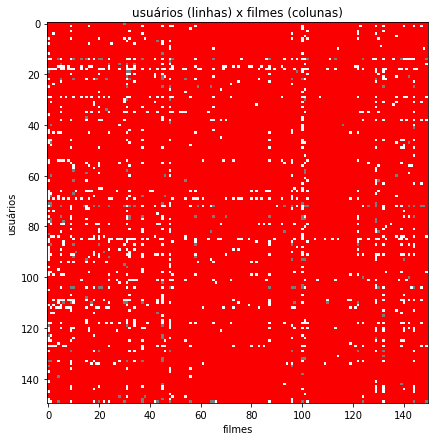

In [33]:
show_ratings = np.zeros((n_users,n_movies,3))
show_ratings[:,:,0] = np.where(grid_ratings == -1., 5, grid_ratings)
show_ratings[:,:,1] = np.where(grid_ratings == -1., 0., grid_ratings)
show_ratings[:,:,2] = np.where(grid_ratings == -1., 0., grid_ratings)


import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(show_ratings[:150,:150,:])
plt.xlabel('filmes')
plt.ylabel('usuários')
plt.show()

## Predições para todos os usuários e filmes

In [34]:
n2p_user,n2p_movie = np.nonzero(grid_ratings==-1)
recommend = model_nn.predict([n2p_user, n2p_movie])

### Montagem da matriz de recomendação "cheia"

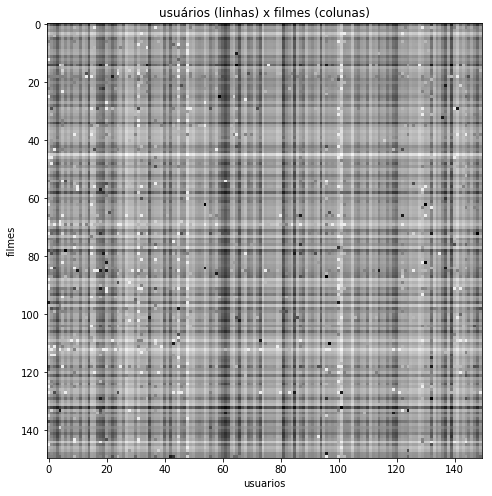

In [35]:
gg = grid_ratings.copy()
gg[n2p_user,n2p_movie] = recommend[:,0]

plt.figure(figsize=(8,8))
plt.title('usuários (linhas) x filmes (colunas)')
plt.xlabel('usuarios')
plt.ylabel('filmes')
plt.imshow(gg[:150,:150],cmap='gray')
plt.show()

### Visualização de uma parte da matriz

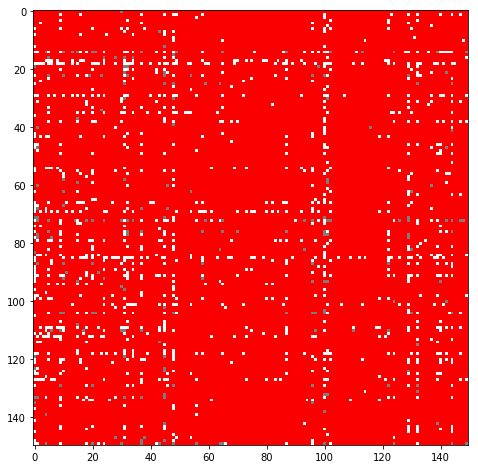

In [36]:
plt.figure(figsize=(8,8))
plt.imshow(show_ratings[:150,:150,:])

### Visualização da parte de usuários mais ativos e filmes mais populares

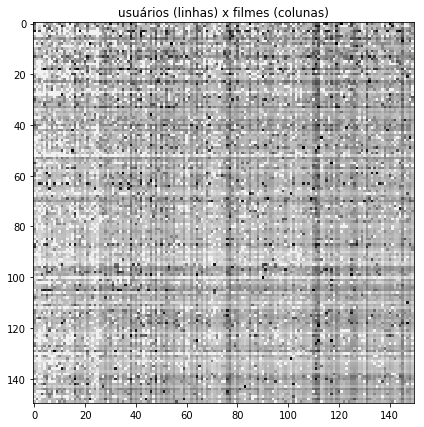

In [37]:
io_popular_movies = np.argsort(h_movieId)[::-1]
io_top_users = np.argsort(h_userId)[::-1].astype(np.int)
gg_ord = gg[np.ix_(io_top_users,io_popular_movies)]
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[:150,:150],cmap='gray')
plt.show()

### Visualização dos usuários menos ativos e filmes menos avaliados

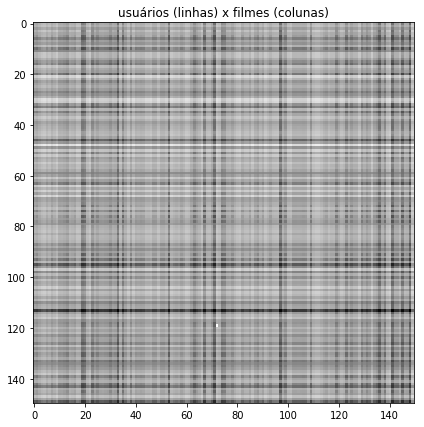

In [38]:
plt.figure(figsize=(7,7))
plt.title('usuários (linhas) x filmes (colunas)')
plt.imshow(gg_ord[-150:,-150:],cmap='gray')
plt.show()

## Analise dos embeddings dos filmes

A análise a seguir será feita apenas com os 2000 filmes mais populares:

In [39]:
topMovies = io_popular_movies[:2000]

### Extração dos atributos latentes (embeddings) dos 2000 fimes mais populares

Para obter os atributos latentes dos 2000 filmes mais populares, primeiro criamos uma
nova rede, denominada `get_movie_emb`, a partir da rede `Model`, com a entrada apenas o ID dos filmes e
a saída `m`, após o embedding. Aplicamos a predição desta rede nos `topMovies`:

In [40]:
get_movie_emb = Model(movie_in, m)
m_emb = get_movie_emb.predict([topMovies])
movie_emb = np.squeeze(m_emb) # elimina dimensões 1
print(m_emb.shape)
movie_emb.shape

(2000, 1, 50)


(2000, 50)

Como o embedding de cada filme tem dimensão 50, é muito difícil conseguir analisá-lo desta forma.
Uma forma muito usual é reduzir esta dimensionalidade utilizando uma técnica denominada PCA -
Principal Component Analysis: [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/).
Iremos reduzir a dimensão dos embeddings de 50 para 3. 

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

#### Filmes com alto valor na primeira dimensão do PCA

In [42]:
fac0 = movie_pca[0]
isort = np.argsort(fac0)[::-1]

for ii in isort[:15]:
    print(fac0[ii],movie_names[ii])

0.0593097541715 Back to the Future Part II (1989)
0.0588120947305 Wings of the Dove, The (1997)
0.0557831428027 Blade (1998)
0.0542483927429 Antz (1998)
0.0524048663518 Patch Adams (1998)
0.0512106121967 Thirty-Two Short Films About Glenn Gould (1993)
0.0504097714649 Governess, The (1998)
0.0501998558442 Mulan (1998)
0.049467252424 Game, The (1997)
0.0491142104826 For Roseanna (Roseanna's Grave) (1997)
0.048582424625 Bullets Over Broadway (1994)
0.0475126007845 Nashville (1975)
0.0471972340323 Hype! (1996)
0.046335572011 Glen or Glenda (1953)
0.0459171675026 Grand Hotel (1932)


#### Filmes com baixo valor na primeira dimensão do PCA

In [43]:
for ii in isort[-15:]:
    print(fac0[ii],movie_names[ii])

-0.0505330724003 Bio-Dome (1996)
-0.0507576533033 Manhattan (1979)
-0.0509349665171 Sudden Death (1995)
-0.0516186545178 Wedding Gift, The (1994)
-0.0517785348547 Coup de torchon (Clean Slate) (1981)
-0.0529157805149 Species (1995)
-0.0529893847309 Jaws 2 (1978)
-0.0533806709975 Johns (1996)
-0.0535604926241 Nixon (1995)
-0.0540831941884 Get Shorty (1995)
-0.0542416736356 La Cérémonie (1995)
-0.0549984971723 Kicking and Screaming (1995)
-0.0575497286336 M. Butterfly (1993)
-0.0665451594452 Grumpier Old Men (1995)
-0.0673167870705 Othello (1995)


### Análise da segunda dimensão do PCA

In [44]:
fac1 = movie_pca[1]
isort = np.argsort(fac1)[::-1]

#### Mais bem avaliados na segunda dimensão

In [45]:
for ii in isort[:15]:
    print(fac1[ii],movie_names[ii])

0.0830059016237 Wings of the Dove, The (1997)
0.0656041012438 Meet the Deedles (1998)
0.0612646105835 Prefontaine (1997)
0.0608206936393 Picture Bride (Bijo photo) (1994)
0.057035507057 Patch Adams (1998)
0.0560848923897 Birds, The (1963)
0.0551363238748 Bad Moon (1996)
0.0545988312993 B*A*P*S (1997)
0.0544926863153 Mulan (1998)
0.054101294812 Edge, The (1997)
0.0536839679176 Cinema Paradiso (Nuovo cinema Paradiso) (1989)
0.0526955688597 Star Trek II: The Wrath of Khan (1982)
0.0498078242617 Wide Awake (1998)
0.0472193446053 Stepford Wives, The (1975)
0.0468186612712 Spellbound (1945)


#### Piores avaliados na segunda dimensão

In [46]:
for ii in isort[-15:]:
    print(fac1[ii],movie_names[ii])

-0.058306109802 Awfully Big Adventure, An (1995)
-0.0588951784488 Wild America (1997)
-0.0594764436414 Reservoir Dogs (1992)
-0.0595829685918 Safe Passage (1994)
-0.0602639346347 Ransom (1996)
-0.0612037826296 Jurassic Park (1993)
-0.0619230325733 Getaway, The (1994)
-0.062751454747 Clockwork Orange, A (1971)
-0.0638041789054 Mediterraneo (1991)
-0.064185844501 Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les) (1964)
-0.066812098165 Labyrinth (1986)
-0.0690309524245 Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)
-0.0736754691986 Jackie Brown (1997)
-0.0751402527971 Bitter Moon (1992)
-0.0758341486 Air Force One (1997)


### Análise da terceira dimensão do PCA

In [47]:
fac2 = movie_pca[2]
isort = np.argsort(fac2)[::-1]

#### Mais bem avaliados na terceira dimensão do PCA

In [48]:
for ii in isort[:15]:
    print(fac2[ii],movie_names[ii])

0.101158863667 Ed (1996)
0.0914145557907 Village of the Damned (1995)
0.0839767763419 Third Man, The (1949)
0.0833304582725 Deceiver (1997)
0.0833135577489 Showgirls (1995)
0.0832407265759 Tex (1982)
0.0796161009338 Vertigo (1958)
0.0789376582916 Ace Ventura: Pet Detective (1994)
0.0749768055823 Kid in King Arthur's Court, A (1995)
0.0740091937827 Thirty-Two Short Films About Glenn Gould (1993)
0.0732584437048 Pocahontas (1995)
0.06859696494 Addiction, The (1995)
0.0682896233329 Grand Hotel (1932)
0.0670440641113 Boys on the Side (1995)
0.064933442701 Junior (1994)


#### Piores avaliados na terceira dimensão do PCA

In [49]:
for ii in isort[-15:]:
    print(fac2[ii],movie_names[ii])

-0.053424583116 Emma (1996)
-0.0545002553525 Blame It on Rio (1984)
-0.0558939415306 Jane Austen's Mafia! (1998)
-0.0571764898852 Jaws 3-D (1983)
-0.0584466481418 Abyss, The (1989)
-0.0595379215019 Man with Two Brains, The (1983)
-0.059546527742 Dragonheart (1996)
-0.0596932508209 For Whom the Bell Tolls (1943)
-0.0619332043417 Flesh and Bone (1993)
-0.0655576253966 Mirage (1995)
-0.0657418434631 Friday the 13th Part VIII: Jason Takes Manhattan (1989)
-0.0701745504779 Net, The (1995)
-0.0739238707184 Amazing Panda Adventure, The (1995)
-0.076511361927 Steal Big, Steal Little (1995)
-0.110151858801 Little Odessa (1994)


### Visualizando duas dimensões do PCA

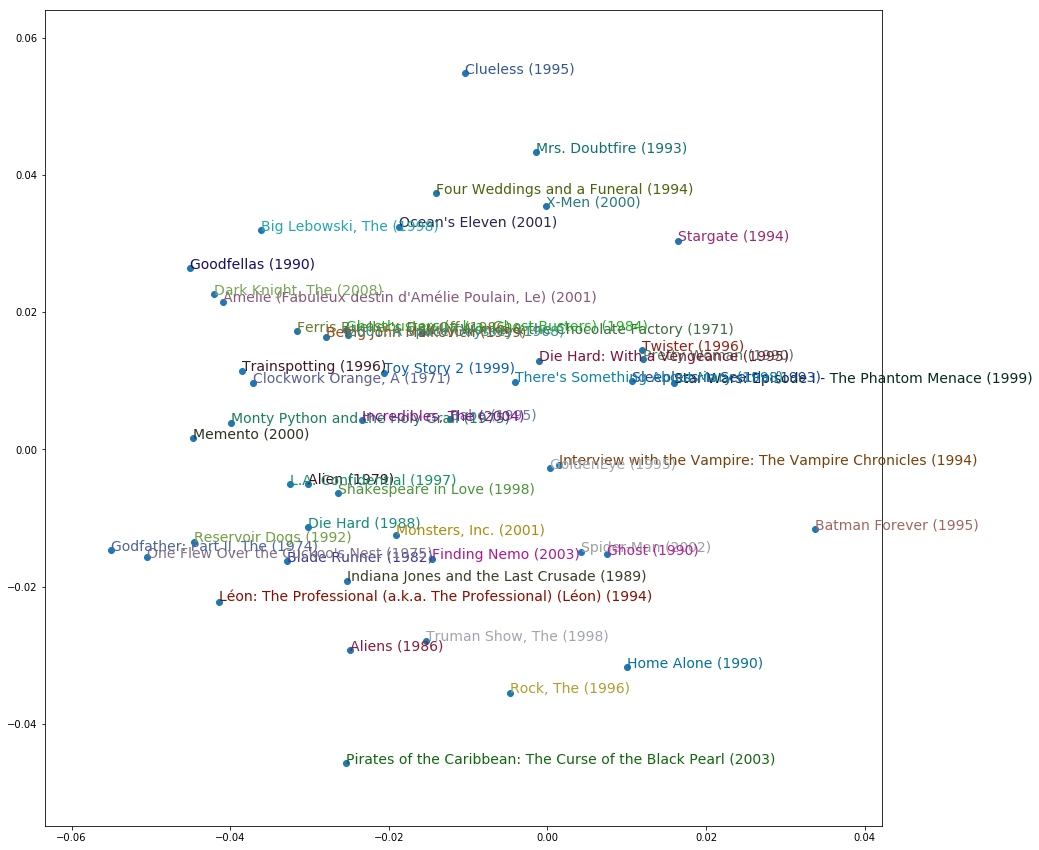

In [50]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Exercícios

1. Inclua um novo usuário, sem nenhuma avaliação. Treine a rede e verifique
   se após a rede treinada, se haverá alguma avaliação.
2. Com o novo usuário, faça uma única avaliação e verifique quais os 10 filmes
   mais recomendados para ele.

## Aprendizados com este notebook